# Imports


In [4]:
import torch
import os
import evaluate
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertConfig , BertModel, DistilBertModel, BertForSequenceClassification, BertForNextSentencePrediction, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import torch.nn as nn
from transformers import AutoModel
from datasets import Dataset

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Set the device and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [16]:
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel,DistilBertModel  # Changed imports
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import torch.nn as nn
from transformers import AutoModel
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Fact and Agrument Classification

This part load dataset will be use to train and test BERT

This dataset was created by our `llama_week_labeling.py` script using `unsloth/llama-3-8b-Instruct-bnb-4bit` model running locally

This dataset need to be created using a week labeling, in this case using llama text generation model, since we can't find usable dataset. 

We use dataset from [`US Election 2020 - Presidential Debates`](https://www.kaggle.com/datasets/headsortails/us-election-2020-presidential-debates) collection and start to create the labels

In [ ]:
# Load datasets
df_fact_agrument_1=pd.read_csv(os.path.join('Datasets','us_debates','fact-agrument','1st_presidential_fact_agument.csv'))
df_fact_agrument_2=pd.read_csv(os.path.join('Datasets','us_debates','fact-agrument','vice_presidential_fact_agrument.csv'))

# Some info about each dataset
df_fact_agrument_1.head(10)
df_fact_agrument_1.info()
df_fact_agrument_1['label'].unique()

df_fact_agrument_2.head(10)
df_fact_agrument_2.info()
df_fact_agrument_2['label'].unique()



,speaker,statement,label
0,Vice President Joe Biden,"How you doing, man?",Argument
1,Vice President Joe Biden,I’m well.,Argument
2,Vice President Joe Biden,"Well, first of all, thank you for doing this a...",Argument
3,Vice President Joe Biden,The American people have a right to have a say...,Argument
4,Vice President Joe Biden,"Now, what’s at stake here is the President’s m...",Argument
5,Vice President Joe Biden,"And that ended when we, in fact, passed the Af...",Argument
6,Vice President Joe Biden,He’s elected to the next election.,Argument
7,Vice President Joe Biden,That’s simply not true.,Argument
8,Vice President Joe Biden,Open discussion.,Argument
9,Vice President Joe Biden,"Number one, he knows what I proposed. What I p...",Argument


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   speaker    563 non-null    object
 1   statement  563 non-null    object
 2   label      563 non-null    object
dtypes: object(3)
memory usage: 13.3+ KB


array(['Argument', 'Fact'], dtype=object)

,speaker,statement,label
0,Kamala Harris,"Thank you, Susan. Well, the American people ha...",Argument
1,Kamala Harris,"Can you imagine if you knew on January 28th, a...",Argument
2,Kamala Harris,… right to reelection based on this.,Argument
3,Kamala Harris,Absolutely. Whatever the vice president is cla...,Argument
4,Kamala Harris,"No. But Susan, this is important. And I want t...",Argument
5,Kamala Harris,"Mr. Vice President, I’m speaking.",Argument
6,Kamala Harris,I’m speaking.,Argument
7,Kamala Harris,Thank you. So I want to ask the American peopl...,Argument
8,Kamala Harris,… when your children-,Argument
9,Kamala Harris,… couldn’t see your parents because you were a...,Argument


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   speaker    157 non-null    object
 1   statement  157 non-null    object
 2   label      157 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB


array(['Argument', 'Fact'], dtype=object)

We also gonna include the `Politifact Fact Check` since the debate we get are more agruments that facts.

We need to create a new dataset from this one with the same format as the one above, and concat the 3

In [ ]:
df_polifact = pd.read_json(os.path.join('Datasets','politifact_factcheck_data.json'), lines=True)
# Cut dataset to randomly 1300 rows, to prevent to many facts
df_polifact = df_polifact.sample(n=1300, random_state=42)

# Dataset for training
df_trainer_final=pd.DataFrame(columns=["speaker", "statement", "label"])

# We add the speaker but is not needed 
# (the speaker information was not use to prevent biases)
df_trainer_final["speaker"]=df_polifact["statement_originator"]
df_trainer_final["statement"]=df_polifact["statement"]
df_trainer_final["label"]="Fact"

# Concat with the 2 early datasets and shuffe dataset
df_trainer_final = pd.concat([df_trainer_final, df_fact_agrument_1, df_fact_agrument_2])
df_trainer_final = df_trainer_final.sample(frac=1, random_state=50).reset_index(drop=True)

# At last we gonna map the lables
label2id = {"Fact": 0, "Argument": 1}
id2label = {v: k for k, v in label2id.items()}  # Reverse mapping
df_trainer_final["label_map"]=df_trainer_final["label"].map(label2id)

df_trainer_final.head(10)
df_trainer_final.info()

,speaker,statement,label,label_map
0,Mike Pence,And I’m going to speak up on behalf of what th...,Argument,1
1,Barack Obama,"""Already we've identified $2 trillion in defic...",Fact,0
2,Kamala Harris,… for the Recovery Act that brought America ba...,Argument,1
3,Vice President Joe Biden,"Because you in fact passed that, that was your...",Argument,1
4,Vice President Joe Biden,Mr. Vice-,Fact,0
5,David Beckham,"""Swaziland has the highest rate of HIV infecti...",Fact,0
6,Facebook posts,Quotes Mike Pence as saying that people with p...,Fact,0
7,Cindy O’Laughlin,"""When comparing state by state, the data clear...",Fact,0
8,Barack Obama,"""We've recovered (from the recession) faster a...",Fact,0
9,President Donald J. Trump,"A lot of people, between drugs and alcohol and...",Argument,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   speaker    2020 non-null   object
 1   statement  2020 non-null   object
 2   label      2020 non-null   object
 3   label_map  2020 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 63.3+ KB


## Training and testing
We decided to use `distilbert-base-uncased` model with the following train hyperparamenters

In [8]:
#Define our models hyperparameters
bert_model_name = 'distilbert-base-uncased' # smaller bert model
num_classes = 6
max_length = 128
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
warmup_steps=500  # number of warmup steps for learning rate scheduler

In [ ]:
def train_fact_agrument_clasifier(model, statement_list: list, labels_list: list, tokenizer):

    def tokenize_function(examples):
        return tokenizer(examples["statement"], padding="max_length", truncation=True, return_tensors="pt")

    # Do a split with stratify to preserve class distribution
    x_train, x_test, y_train, y_test = train_test_split(statement_list, labels_list, test_size=0.35, stratify=labels_list)

    # Create new train and test dataset
    train_data = Dataset.from_dict({
        'statement': [t[0] for t in x_train],
        'label': [int(label) for label in y_train]
    })

    test_data = Dataset.from_dict({
        'statement': [t[0] for t in x_test],
        'label': [int(label) for label in y_test]
    })

    # Map the train and text dataset with the tokeneizer
    train_data = train_data.map(tokenize_function, batched=True)
    test_data = test_data.map(tokenize_function, batched=True)

    # Remove original text columns (keep only tokenized inputs)
    train_data = train_data.remove_columns(["statement"])
    test_data = test_data.remove_columns(["statement"])

    # Use acuracy as the metric
    def compute_metrics(eval_pred):
        metric = evaluate.load("accuracy")
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = metric.compute(predictions=predictions, references=labels)
        return accuracy
    
    # Define training agruments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        save_total_limit=2,  # limit the total amount of checkpoints, delete the older checkpoints
        eval_steps=500, # Perform evaluation every 100 steps
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        metric_for_best_model="accuracy",  # Metric to use for selecting the best model
        greater_is_better=True,  # Whether a higher value of the metric is better
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,  # training data
        eval_dataset=test_data,  # evaluation data
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model("./models/distilbert_fact_agrument_classifier")
    tokenizer.save_pretrained("./models/distilbert_fact_agrument_classifier")

    # Reload with new model
    model = BertForNextSentencePrediction.from_pretrained("./models/distilbert_fact_agrument_classifier").to(device)
    tokenizer = BertTokenizer.from_pretrained("./models/distilbert_fact_agrument_classifier")

In [ ]:
# Load default model
config = BertConfig.from_pretrained(bert_model_name, num_labels=len(label2id), label2id=label2id, id2label=id2label)
model = BertForSequenceClassification.from_pretrained(bert_model_name, config=config).to(device)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Training
statement_train_list=df_trainer_final["statement"].to_list()
labels_list=df_trainer_final["label_map"].to_list()

train_fact_agrument_clasifier(model, statement_train_list, labels_list, tokenizer)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

{'loss': 0.4781, 'grad_norm': 3.4415032863616943, 'learning_rate': 2e-05, 'epoch': 3.03}


 61%|██████    | 1000/1650 [07:12<05:09,  2.10it/s]

{'loss': 0.3766, 'grad_norm': 2.8233494758605957, 'learning_rate': 1.1304347826086957e-05, 'epoch': 6.06}


 91%|█████████ | 1500/1650 [11:05<01:11,  2.09it/s]

{'loss': 0.3534, 'grad_norm': 3.7257838249206543, 'learning_rate': 2.6086956521739132e-06, 'epoch': 9.09}


100%|██████████| 1650/1650 [12:19<00:00,  2.23it/s]


{'train_runtime': 739.4974, 'train_samples_per_second': 17.755, 'train_steps_per_second': 2.231, 'train_loss': 0.39714479157418914, 'epoch': 10.0}


Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at ./models/distilbert_fact_agrument_classifier and are newly initialized: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluate models perfomance
To evaluate the model we gonna give some text samples from polifact website and some text from the debates dataset

In [ ]:
# Reload new model
model = BertForSequenceClassification.from_pretrained("./models/distilbert_fact_agrument_classifier").to(device)

# Function to test the sentiment of a text
def test_model(text, model, tokenizer):
    labels = {0: "Fact", 1: "Argument"}
    # Tokenize the text and add padding/truncation
    encoding = tokenizer(text, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Make the model prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1).item()  # Convert logits to predicted class index

    # Output the prediction label based on the model's class index
    predicted_label = labels[predictions]  # Map the predicted index to the label
    print(f"Sentiment for text: '{text}' is {predicted_label}")


# Test sentiment prediction
test_model("The poverty rate decreased by 3% in the last two years", model, tokenizer) # Fact
test_model("FEMA sent $59M LAST WEEK to luxury hotels in New York City to house illegal migrants… That money is meant for American disaster relief.", model, tokenizer) # Agrument
test_model("But many people are catching it. Many people are getting this disease that was sent to us by China, and it shouldn’t have been allowed to happen.", model, tokenizer) # Agrument

Sentiment for text: 'The poverty rate decreased by 3% in the last two years' is Fact
Sentiment for text: 'FEMA sent $59M LAST WEEK to luxury hotels in New York City to house illegal migrants… That money is meant for American disaster relief.' is Fact
Sentiment for text: 'But many people are catching it. Many people are getting this disease that was sent to us by China, and it shouldn’t have been allowed to happen.' is Argument


# Fact Analyses
We need to classifie agruments as `true` or `false`.

For that we will use the `Politifact Fact Check` and `Snopes Fact-news Data` datasets from the EDA

## Define Data Processing
This defines a Custom Dataset class to treat our data for Fact Checking

In [9]:
from torch.utils.data import Dataset as tDataset

class CustomDataset(tDataset):
    def __init__(self, data, tokenizer, labels, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]["sentence"]
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

### Pre Processing Data function
We frist start to tranform all the labels in true or false.

Only the labels `true` and `mostly-true` are considered as `true: 1` and the other labels are considered `false: 0`.

One area of improvement in the future, is to use the other labels provided by the datasets of the websites (or even create custom ones).

We also remove all the unwanted colums and add `None` to empty values of the remaining columns.

In [10]:
def data_preprocessing(dataset):
  
  #turn label either false or true
  dataset['label']=[1 if x=="true"or x=="mostly-true" or x=="half-true" else 0 for x in dataset[1]] 

  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

## Defining BERT Train functions
- Define BERT Model with classification head
- Define the function to train the model
- Define evaluate method
- Define function to predict a verdict


In [11]:
import torch.nn as nn
from transformers import AutoModel
from transformers import (
    BertForSequenceClassification,    
    BertTokenizer,
    AdamW)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Classification Head
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)  # Binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_embedding)
        x = self.fc(x)
        return self.softmax(x)


# Train Function
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    progress_bar = tqdm(data_loader, desc="Training", leave=True)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

# Evaluation Function
def evaluate_model(model, data_loader,device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(actual_labels, predictions)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

# Label predict Function
def predict_label(text, model, tokenizer, device, label_encoder, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_class = torch.argmax(outputs, dim=1).item()

    return label_encoder.inverse_transform([pred_class])[0]  # Return actual label
    

## Training and testing
We decided to use `distilbert-base-uncased` model with the following train hyperparamenters

In [12]:
#Define our models hyperparameters
bert_model_name = 'distilbert-base-uncased'
num_classes = 6
max_length = 128
batch_size = 8
num_epochs = 10
learning_rate = 2e-5

### Combining Both DS

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# Loading the data

# Load the LIAR dataset from TSV
#df1 = pd.read_csv(os.path.join('Datasets','LIAR.tsv'), sep="\t", header=None)
# Load the POLITIFACT dataset
df2 = pd.read_json(os.path.join('Datasets','politifact_factcheck_data.json'), lines=True)

#---------------Preprocess LIAR dataset----------------------
#df1 = data_preprocessing(df1)

#---------------Preprocess Politifact dataset----------------------
df2["sentence"] = df2["statement_originator"] + " said: " + df2["statement"] + " (" + df2["statement_date"] + " via " + df2["statement_source"] + ")"

# Encode labels: 1 for true, mostly-true, half-true, barely-true; 0 otherwise
df2['label'] = df2['verdict'].apply(lambda x: 1 if x in ['true', 'mostly-true'] else 0)

# Handle metadata and combine into a single column
meta_columns = ["statement_originator", "statement_date", "statement_source"]
df2['metadata'] = df2[meta_columns].fillna('None').astype(str).agg(' '.join, axis=1)

# Create sentence column combining metadata and statement
df2["sentence"] = df2["metadata"] + " " + df2["statement"]

# Drop original columns (optional)
df2 = df2.drop(columns=meta_columns + ["statement", "verdict","metadata","factcheck_analysis_link","factchecker", "factcheck_date"])


#df = pd.concat([df1, df2])
df = df2
df.fillna("None", inplace=True)
df = df.dropna()

#split data
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df["sentence"].tolist(), df["label"].tolist(), test_size=0.2)	

train_data = [{"sentence" : stm, "label" : vrd} for stm, vrd in zip(train_sentences, train_labels)]
val_data = [{"sentence" : stm, "label" : vrd} for stm, vrd in zip(val_sentences, val_labels)]

print("Train data size:", len(train_data))
print("train data", train_data[0])




Train data size: 16921
train data {'sentence': 'David Dewhurst 2/16/2010 email During "the recent global warming summit in Copenhagen, Nancy Pelosi and others stayed at a five-star hotel on a trip costing nearly $10,000 per person."', 'label': 1}


In [14]:
df.head(500)

,sentence,label
0,Barack Obama 6/11/2008 speech John McCain oppo...,1
1,"Matt Gaetz 6/7/2022 television ""Bennie Thompso...",0
2,Kelly Ayotte 5/18/2016 news Says Maggie Hassan...,1
3,"Bloggers 2/1/2021 blog ""BUSTED: CDC Inflated C...",0
4,"Bobby Jindal 8/30/2015 television ""I'm the onl...",0
...,...,...
495,"Dana Young 10/20/2016 other Says she ""voted fo...",0
496,"Viral image 1/1/2021 social_media ""President-e...",0
497,Michael MacDonald 3/24/2021 statement Michigan...,0
498,Vincent Fort 7/6/2010 other Says Democratic op...,0


In [15]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

# Create DataLoaders, from pytorch (this gives me an error)
train_dataset = CustomDataset(train_data, tokenizer,train_labels)
val_dataset = CustomDataset(val_data, tokenizer,val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Set the device and load the model
model = BERTClassifier(bert_model_name).to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


### Training and save the model


c:\Users\jaime\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


Training: 100%|██████████| 2116/2116 [03:32<00:00,  9.97it/s]


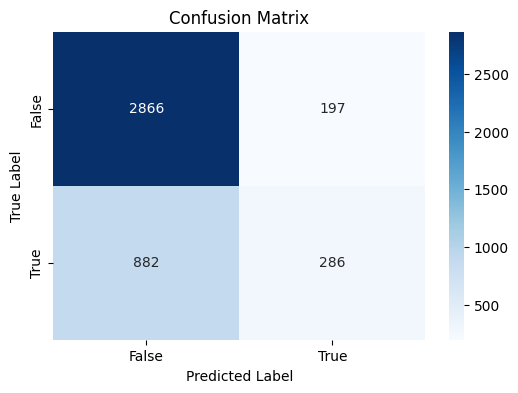

Validation Accuracy: 0.7450
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      3063
           1       0.59      0.24      0.35      1168

    accuracy                           0.74      4231
   macro avg       0.68      0.59      0.59      4231
weighted avg       0.72      0.74      0.70      4231

Epoch 2/10


Training: 100%|██████████| 2116/2116 [03:43<00:00,  9.46it/s]


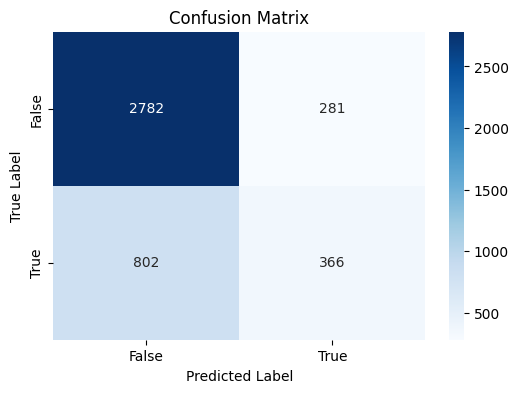

Validation Accuracy: 0.7440
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      3063
           1       0.57      0.31      0.40      1168

    accuracy                           0.74      4231
   macro avg       0.67      0.61      0.62      4231
weighted avg       0.72      0.74      0.72      4231

Epoch 3/10


Training: 100%|██████████| 2116/2116 [03:48<00:00,  9.27it/s]


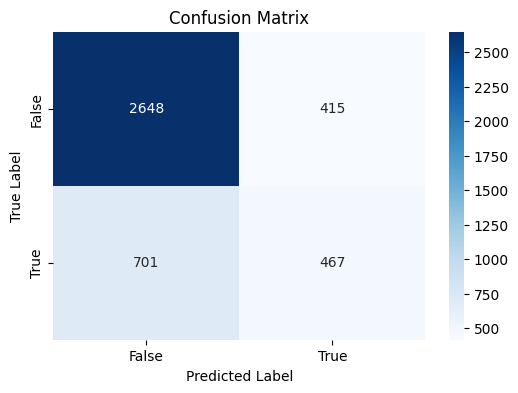

Validation Accuracy: 0.7362
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      3063
           1       0.53      0.40      0.46      1168

    accuracy                           0.74      4231
   macro avg       0.66      0.63      0.64      4231
weighted avg       0.72      0.74      0.72      4231

Epoch 4/10


Training: 100%|██████████| 2116/2116 [03:54<00:00,  9.02it/s]


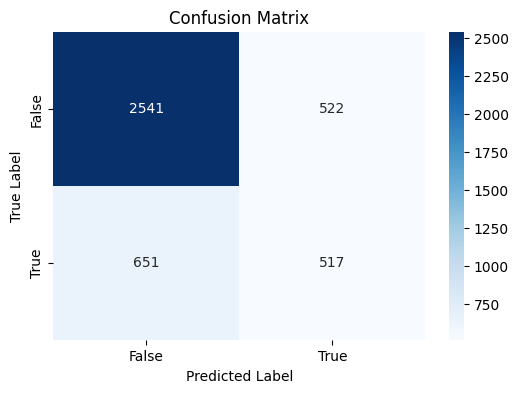

Validation Accuracy: 0.7228
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3063
           1       0.50      0.44      0.47      1168

    accuracy                           0.72      4231
   macro avg       0.65      0.64      0.64      4231
weighted avg       0.71      0.72      0.72      4231

Epoch 5/10


Training: 100%|██████████| 2116/2116 [03:58<00:00,  8.87it/s]


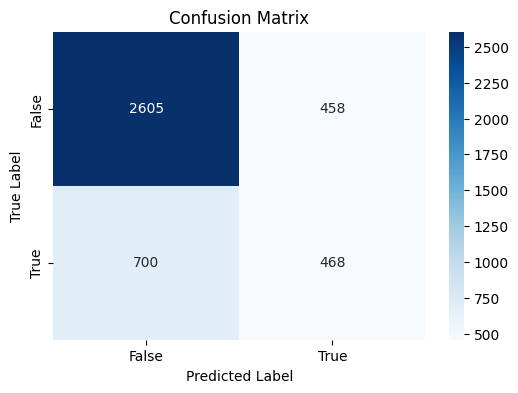

Validation Accuracy: 0.7263
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3063
           1       0.51      0.40      0.45      1168

    accuracy                           0.73      4231
   macro avg       0.65      0.63      0.63      4231
weighted avg       0.71      0.73      0.72      4231

Epoch 6/10


Training: 100%|██████████| 2116/2116 [03:54<00:00,  9.04it/s]


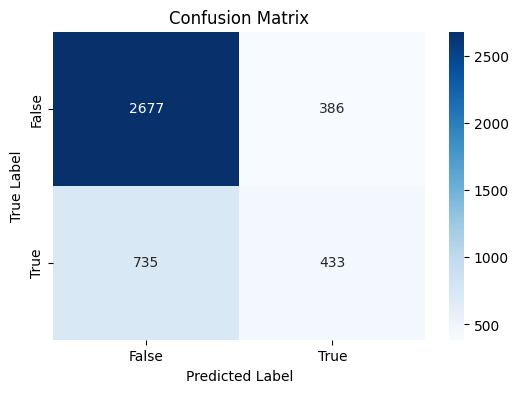

Validation Accuracy: 0.7351
              precision    recall  f1-score   support

           0       0.78      0.87      0.83      3063
           1       0.53      0.37      0.44      1168

    accuracy                           0.74      4231
   macro avg       0.66      0.62      0.63      4231
weighted avg       0.71      0.74      0.72      4231

Epoch 7/10


Training: 100%|██████████| 2116/2116 [04:04<00:00,  8.65it/s]


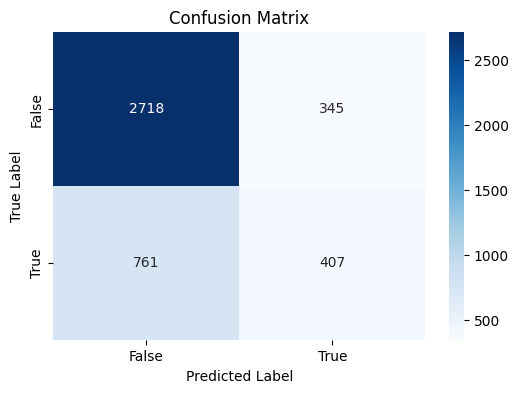

Validation Accuracy: 0.7386
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      3063
           1       0.54      0.35      0.42      1168

    accuracy                           0.74      4231
   macro avg       0.66      0.62      0.63      4231
weighted avg       0.71      0.74      0.72      4231

Epoch 8/10


Training: 100%|██████████| 2116/2116 [03:57<00:00,  8.90it/s]


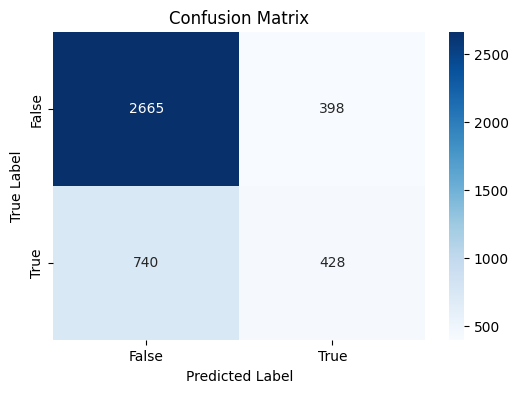

Validation Accuracy: 0.7310
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3063
           1       0.52      0.37      0.43      1168

    accuracy                           0.73      4231
   macro avg       0.65      0.62      0.63      4231
weighted avg       0.71      0.73      0.72      4231

Epoch 9/10


Training: 100%|██████████| 2116/2116 [04:03<00:00,  8.67it/s]


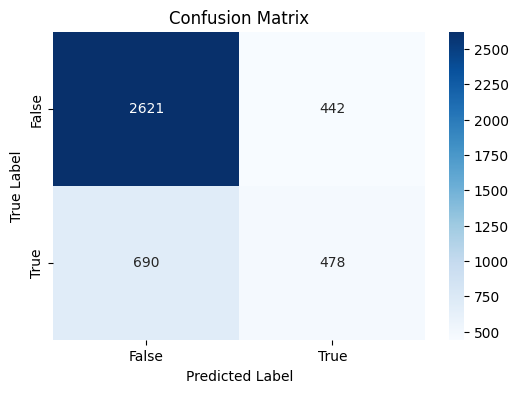

Validation Accuracy: 0.7325
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3063
           1       0.52      0.41      0.46      1168

    accuracy                           0.73      4231
   macro avg       0.66      0.63      0.64      4231
weighted avg       0.72      0.73      0.72      4231

Epoch 10/10


Training: 100%|██████████| 2116/2116 [04:02<00:00,  8.73it/s]


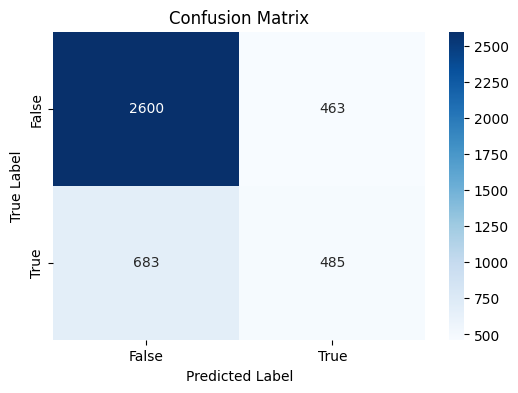

Validation Accuracy: 0.7291
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3063
           1       0.51      0.42      0.46      1168

    accuracy                           0.73      4231
   macro avg       0.65      0.63      0.64      4231
weighted avg       0.71      0.73      0.72      4231



RuntimeError: Parent directory models does not exist.

In [17]:
# Optimizer and scheduler
# AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Total number of training steps, being the number of batches * number of epochs
total_steps = len(train_dataloader) * num_epochs 
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)


for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate_model(model, val_dataloader,device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

torch.save(model.state_dict(), os.path.join("models","distilbert_fact_classifier.pth"))

### Evaluate models perfomance
To evaluate the model we gonna give some text samples from polifact website:

In [ ]:
# Reload new model
model.load_state_dict(torch.load('./models/distilbert_fact_classifier.pth', weights_only=False))
model = model.to(device)

# Function to test the sentiment of a text
def test_sentiment(text, model, tokenizer):
    label_encoder = LabelEncoder()
    label_encoder.fit(['False', 'True'])
    sentiment = predict_label(text, model, tokenizer, device, label_encoder)
    print(f"Predicted sentiment: {sentiment}")

# Test sentiment prediction
test_sentiment("The poverty rate decreased by 3% in the last two years", model, tokenizer) # True
test_sentiment("FEMA sent $59M LAST WEEK to luxury hotels in New York City to house illegal migrants… That money is meant for American disaster relief.", model, tokenizer) # False
test_sentiment("Former USAID Administrator Samantha Power’s net worth “skyrocketed” from $6.7 million to $30 million in three years.", model, tokenizer) # False

<All keys matched successfully>

Predicted sentiment: True
Predicted sentiment: True
Predicted sentiment: False


# Agrument Analyses
This part load dataset will be use to train and test BERT

This dataset was also created by our `llama_week_labeling.py` script.

We use dataset from [`US Election 2020 - Presidential Debates`](https://www.kaggle.com/datasets/headsortails/us-election-2020-presidential-debates) collection and start to create the labels:
- `Restatement`: The second statement restates or reinforces the first.
- `Counterargument`: The second statement opposes the first.
- `Neutral`: No clear relationship between the statements.

In [ ]:
# Define the labels
label2id = {"Neutral": 0, "Counterargument": 1, "Restatement": 2}
id2label = {v: k for k, v in label2id.items()}  # Reverse mapping

# Load datasets for training
df_agrument_1=pd.read_csv(os.path.join('Datasets','us_debates','agrument','1st_presidential_agrument.csv'))
# Only one speaker
df_agrument_2=pd.read_csv(os.path.join('Datasets','us_debates','agrument','trump_town_hall_agrument.csv'))

# Map the labels
df_agrument_1["label_map"]=df_agrument_1["label"].map(label2id)
df_agrument_2["label_map"]=df_agrument_2["label"].map(label2id)

# Print some dataset information
df_agrument_1.info()
df_agrument_1.head()
df_agrument_2.info()
df_agrument_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker1    745 non-null    object
 1   statement1  745 non-null    object
 2   speaker2    745 non-null    object
 3   statement2  745 non-null    object
 4   label       745 non-null    object
 5   label_map   745 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 35.1+ KB


,speaker1,statement1,speaker2,statement2,label,label_map
0,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,How are you doing?,Neutral,0
1,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Counterargument,1
2,Vice President Joe Biden,I’m well.,President Donald J. Trump,How are you doing?,Neutral,0
3,Vice President Joe Biden,I’m well.,President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Neutral,0
4,Vice President Joe Biden,I’m well.,President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker1    416 non-null    object
 1   statement1  416 non-null    object
 2   speaker2    416 non-null    object
 3   statement2  416 non-null    object
 4   label       416 non-null    object
 5   label_map   416 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 19.6+ KB


,speaker1,statement1,speaker2,statement2,label,label_map
0,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",President Trump,"I’m feeling great, I don’t know about you. How...",Neutral,0
1,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",President Trump,"It’s great to be back in my home state, Florid...",Counterargument,1
2,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",President Trump,"I’m feeling great, I don’t know about you. How...",Neutral,0
3,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",President Trump,"It’s great to be back in my home state, Florid...",Neutral,0
4,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",President Trump,My goal is to fight for you and fight for your...,Neutral,0


In [ ]:
# Concat the 2 early datasets
df_trainer_final = pd.concat([df_agrument_1, df_agrument_2])
df_trainer_final.head(10)
df_trainer_final.info()

,speaker1,statement1,speaker2,statement2,label,label_map
0,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,How are you doing?,Neutral,0
1,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Counterargument,1
2,Vice President Joe Biden,I’m well.,President Donald J. Trump,How are you doing?,Neutral,0
3,Vice President Joe Biden,I’m well.,President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Neutral,0
4,Vice President Joe Biden,I’m well.,President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1
5,Vice President Joe Biden,"Well, first of all, thank you for doing this a...",President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Neutral,0
6,Vice President Joe Biden,"Well, first of all, thank you for doing this a...",President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1
7,Vice President Joe Biden,"Well, first of all, thank you for doing this a...",President Donald J. Trump,"Thank you, Joe.",Neutral,0
8,Vice President Joe Biden,The American people have a right to have a say...,President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1
9,Vice President Joe Biden,The American people have a right to have a say...,President Donald J. Trump,"Thank you, Joe.",Neutral,0


<class 'pandas.core.frame.DataFrame'>
Index: 1161 entries, 0 to 415
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker1    1161 non-null   object
 1   statement1  1161 non-null   object
 2   speaker2    1161 non-null   object
 3   statement2  1161 non-null   object
 4   label       1161 non-null   object
 5   label_map   1161 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 63.5+ KB


## Training and testing
We decided to use `distilbert-base-uncased` model with the following train hyperparamenters

In [ ]:
#Define our models hyperparameters
bert_model_name = 'distilbert-base-uncased' # smaller bert model
num_classes = 6
max_length = 128
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
warmup_steps=500  # number of warmup steps for learning rate scheduler

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["statement1"], examples["statement2"], padding="max_length", truncation=True, return_tensors="pt")

def train_agrument_clasifier(model, statement1_train_list: list, statement2_train_list: list, labels_list: list, tokenizer):

    x = list(zip(statement1_train_list, statement2_train_list))
    y = labels_list

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, stratify=y)

    # Do a split with stratify to preserve class distribution
    train_data = Dataset.from_dict({
        'statement1': [t[0] for t in x_train],
        'statement2': [t[1] for t in x_train],
        'label': [int(label) for label in y_train]
    })

    test_data = Dataset.from_dict({
        'statement1': [t[0] for t in x_test],
        'statement2': [t[1] for t in x_test],
        'label': [int(label) for label in y_test]
    })

    train_data = train_data.map(tokenize_function, batched=True)
    test_data = test_data.map(tokenize_function, batched=True)

    # Remove original text columns (keep only tokenized inputs)
    train_data = train_data.remove_columns(["statement1", "statement2"])
    test_data = test_data.remove_columns(["statement1", "statement2"])

    def compute_metrics(eval_pred):
        metric = evaluate.load("accuracy")
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = metric.compute(predictions=predictions, references=labels)
        return accuracy

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        save_total_limit=2,  # limit the total amount of checkpoints, delete the older checkpoints
        eval_steps=500, # Perform evaluation every 100 steps
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        metric_for_best_model="accuracy",  # Metric to use for selecting the best model
        greater_is_better=True,  # Whether a higher value of the metric is better
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,  # training data
        eval_dataset=test_data,  # evaluation data
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model("./models/distilbert_agrument_classifier")
    tokenizer.save_pretrained("./models/distilbert_agrument_classifier")

    # Reload with new model
    model = BertForSequenceClassification.from_pretrained("./models/distilbert_agrument_classifier").to(device)
    tokenizer = BertTokenizer.from_pretrained("./models/distilbert_agrument_classifier")

# Load default model
config = BertConfig.from_pretrained(bert_model_name, num_labels=len(label2id), label2id=label2id, id2label=id2label)
model = BertForSequenceClassification.from_pretrained(bert_model_name, config=config).to(device)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Training
statement1_train_list=df_trainer_final["statement1"].to_list()
statement2_train_list=df_trainer_final["statement2"].to_list()
labels_list=df_trainer_final["label_map"].to_list()

train_agrument_clasifier(model, statement1_train_list, statement2_train_list, labels_list, tokenizer)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

{'loss': 0.5929, 'grad_norm': 2.6982288360595703, 'learning_rate': 2e-05, 'epoch': 5.26}


100%|██████████| 950/950 [06:39<00:00,  2.38it/s]


{'train_runtime': 399.7395, 'train_samples_per_second': 18.862, 'train_steps_per_second': 2.377, 'train_loss': 0.4776993922183388, 'epoch': 10.0}


### Evaluate models perfomance
To evaluate the model we gonna give some agrument pre classified by llama:

In [ ]:
# Function to test the sentiment of a text
from transformers import pipeline
nli_model = pipeline("text-classification", model="./models/distilbert_agrument_classifier", device=device)

def test_model(statement1, statement2, model, tokenizer):
    input_text=f"{statement1} </s></s> {statement2}"
    model_result=model(input_text, truncation=True)
    print(f"Classification is {model_result[0]['label']}")

# Test sentiment prediction
test_model("The deal is that it’s going to wipe out pre-existing conditions. And, by the way, the 200,000 people that have died on his watch, how many of those have survived? Well, there’s seven million people that contracted COVID."
           ,"And if you were here, it wouldn’t be 200, it would be two million people because you were very late on the draw. You didn’t want me to ban China, which was heavily infected. You didn’t want me to ban Europe", 
           nli_model, tokenizer) # Counterargument
test_model("People want to be safe.","Those states are not doing well that are shut down right now.", nli_model, tokenizer) # Neutral
test_model("People want to be safe.", "Because it’s a political thing.", nli_model, tokenizer) # Counterargument

Classification is Counterargument
Classification is Counterargument
Classification is Counterargument
